In [69]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

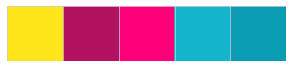

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

#color
from colorama import Fore, Style

# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [71]:
# List files available
IMAGE_PATH = "input/osic-pulmonary-fibrosis-progression/"
list(os.listdir(IMAGE_PATH))

df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_test = pd.read_csv(IMAGE_PATH + 'test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,df_train.shape)

Training data shape:   (1549, 7)


In [72]:
df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [73]:
df_train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [74]:
## Helper functions

def cat_to_binary(value, cat_name):
    if value == cat_name:
        return 1
    else:
        return 0

## evaluation metric function
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

In [75]:
## default benchmark
laplace_log_likelihood(df_train.FVC, np.mean(df_train.FVC), np.std(df_train.FVC))

-8.023182671302116

This plot shows most of the patients are from 65 to 75 years old.


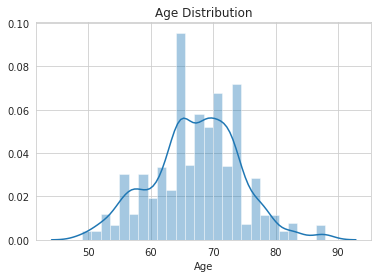

In [76]:
## Age Distribution
a = sns.distplot(df_train['Age'])
a.set_title('Age Distribution')
print("This plot shows most of the patients are from 65 to 75 years old.")

Text(0.5, 0.98, 'Distribution of Smoking Status by Sex')

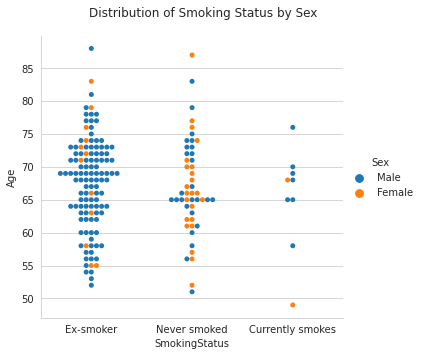

In [77]:
## Smoker-Age-Distribution
df= df_train
df= df.drop_duplicates(subset='Patient',keep='first')
s = sns.catplot(x="SmokingStatus", y="Age", hue="Sex", kind="swarm", data=df)
plt.subplots_adjust(top=0.9)
s.fig.suptitle('Distribution of Smoking Status by Sex')

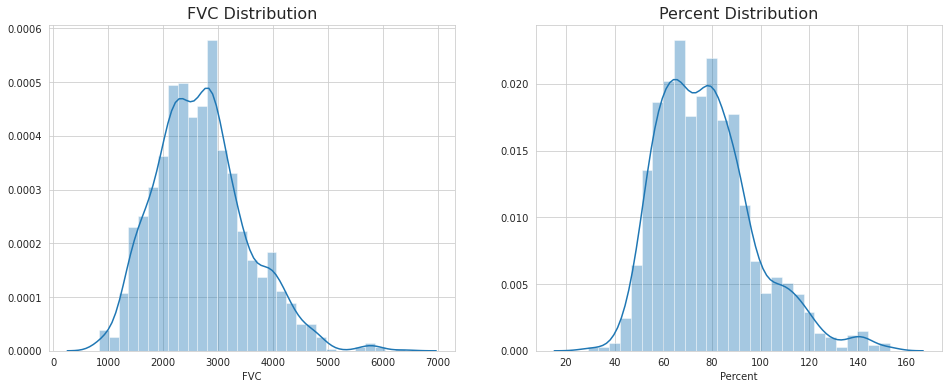

In [78]:
# FVC Distribution
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(df_train["FVC"], ax=ax1, hist=True)
b = sns.distplot(df_train["Percent"], ax=ax2, hist=True)

a.set_title("FVC Distribution", fontsize=16)
b.set_title("Percent Distribution", fontsize=16);

In [79]:
def calculate_gradient_coef_for_patient(patient_records_df):
    X_train = patient_records_df[['Weeks']]
    y_train = patient_records_df[['FVC']]

    model = LinearRegression(normalize=True).fit(X_train, y_train)
    return model.coef_[0][0]

In [80]:
def prepare_patient_data(df_raw, patient_id, df_new):
    """
    Calculates weekly change for each unique patient
    :param df_raw:
    :param patient_id:
    :param df_new:
    :return:
    """
    patient_records_df = df_raw[df_raw.Patient == patient_id]

    # sns.regplot(x=patient_records_df['Weeks'], y=patient_records_df['FVC'])
    # plt.title(patient_id)
    # plt.ylim(1000, 4000)
    # plt.xlim(-12, 133)
    # plt.show()

    number_records = len(patient_records_df)
    gradient_coef = calculate_gradient_coef_for_patient(patient_records_df)
    max_fvc = patient_records_df[['FVC']].max()[0]
    min_fvc = patient_records_df[['FVC']].min()[0]
    std_fvc = patient_records_df[['FVC']].std()[0]
    if np.isnan(std_fvc):
        std_fvc = 0

    first_measurement = patient_records_df.iloc[0]
    last_measurement = patient_records_df.iloc[number_records - 1]
    diff_abs_fvc = last_measurement['FVC'] - first_measurement['FVC']
    # print('L {} - F {} = {}'.format(last_measurement['FVC'], first_measurement['FVC'], diff_abs_fvc))
    df_unique_patient = pd.DataFrame(
        index=[patient_id],
        columns=[
            'FVC_First', 
            'FVC_Last', 
            'Diff_FVC_Abs', 
            'Gradient_Coef', 
            'Max_FVC', 
            'Min_FVC', 
            'Std_FVC'
        ],
        data=[[
            first_measurement['FVC'], 
            last_measurement['FVC'], 
            diff_abs_fvc, 
            gradient_coef, 
            max_fvc, 
            min_fvc, 
            std_fvc]]
    )
    df_unique_patient['Percent'] = first_measurement['Percent']
    df_unique_patient['Age'] = first_measurement['Age']
    df_unique_patient['Sex'] = first_measurement['Sex']
    df_unique_patient['SmokingStatus'] = first_measurement['SmokingStatus']
    df_unique_patient['Male'] = cat_to_binary(first_measurement['Sex'], 'Male')
    df_unique_patient['Female'] = cat_to_binary(first_measurement['Sex'], 'Female')
    df_unique_patient['NeverSmoked'] = cat_to_binary(first_measurement['SmokingStatus'], 'Never smoked')
    df_unique_patient['ExSmoker'] = cat_to_binary(first_measurement['SmokingStatus'], 'Ex-smoker')
    df_unique_patient['CurrentlySmokes'] = cat_to_binary(first_measurement['SmokingStatus'], 'Currently smokes')

    df_new = df_new.append(df_unique_patient)
    return df_new

In [81]:
def prepare_unique_patients_df(df_raw):
    df_unique_patients = pd.DataFrame(
        columns=[
            'FVC_First',
            'FVC_Last',
            'Diff_FVC_Abs',
            'Gradient_Coef',
            'Max_FVC',
            'Min_FVC',
            'Std_FVC',
            'Percent',
            'Age',
            'Sex',
            'SmokingStatus',
            'Male',
            'Female',
            'NeverSmoked',
            'ExSmoker',
            'CurrentlySmokes'
        ])
    unique_patient_ids = df_raw['Patient'].unique()
    for patient_id in unique_patient_ids:
        df_unique_patients = prepare_patient_data(df_raw, patient_id, df_unique_patients)
    return df_unique_patients

In [82]:
# create dataframe for unique patients
df_unique_patients = prepare_unique_patients_df(df_train)
df_unique_patients.head()

,FVC_First,FVC_Last,Diff_FVC_Abs,Gradient_Coef,Max_FVC,Min_FVC,Std_FVC,Percent,Age,Sex,SmokingStatus,Male,Female,NeverSmoked,ExSmoker,CurrentlySmokes
ID00007637202177411956430,2315,2057,-258,-3.167126,2315,2000,96.856136,58.253649,79,Male,Ex-smoker,1,0,0,1,0
ID00009637202177434476278,3660,3214,-446,-9.379955,3895,3214,197.367677,85.282878,69,Male,Ex-smoker,1,0,0,1,0
ID00010637202177584971671,3523,2518,-1005,-17.042803,3523,2474,358.433901,94.724672,60,Male,Ex-smoker,1,0,0,1,0
ID00011637202177653955184,3326,3193,-133,-4.548925,3541,3193,113.773899,85.987590,72,Male,Ex-smoker,1,0,0,1,0
ID00012637202177665765362,3418,2971,-447,-8.543079,3759,2971,212.432211,93.726006,65,Male,Never smoked,1,0,1,0,0


,FVC_First,FVC_Last,Diff_FVC_Abs,Gradient_Coef,Max_FVC,Min_FVC,Std_FVC,Percent,Age,Sex,SmokingStatus,Male,Female,NeverSmoked,ExSmoker,CurrentlySmokes
ID00007637202177411956430,2315,2057,-258,-3.167126,2315,2000,96.856136,58.253649,79,Male,Ex-smoker,1,0,0,1,0
ID00009637202177434476278,3660,3214,-446,-9.379955,3895,3214,197.367677,85.282878,69,Male,Ex-smoker,1,0,0,1,0
ID00010637202177584971671,3523,2518,-1005,-17.042803,3523,2474,358.433901,94.724672,60,Male,Ex-smoker,1,0,0,1,0
ID00011637202177653955184,3326,3193,-133,-4.548925,3541,3193,113.773899,85.987590,72,Male,Ex-smoker,1,0,0,1,0
ID00012637202177665765362,3418,2971,-447,-8.543079,3759,2971,212.432211,93.726006,65,Male,Never smoked,1,0,1,0,0


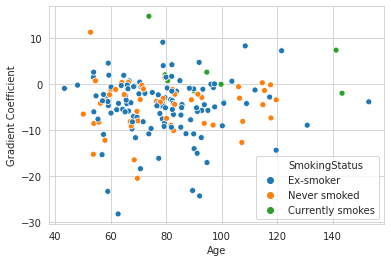

In [83]:
sns.scatterplot(
    x=df_unique_patients['Percent'],
    y=df_unique_patients['Gradient_Coef'],
    hue=df_unique_patients['SmokingStatus'],
)
plt.xlabel('Age')
plt.ylabel('Gradient Coefficient')
df_unique_patients.head()

In [84]:
# Get Average Gradient Coefficient across all patients
mean_gradient_coef = df_unique_patients.Gradient_Coef.mean()
mean_std_fvc = df_unique_patients.Std_FVC.mean()
print('Mean coefficient: ', mean_gradient_coef)
print('Mean Standard Deviation: ', mean_std_fvc)

Mean coefficient:  -4.52430144243629
Mean Standard Deviation:  154.8115965322575


Text(0.5, 0, 'Gradient Coefficient (= weekly change in FVC)')

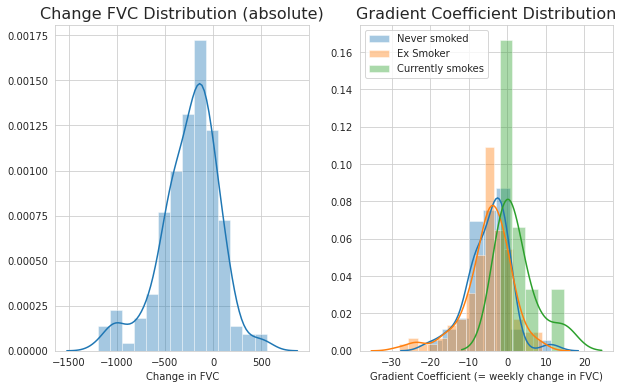

In [85]:
# Change FVC Distribution (absolute) Gradient Coefficient Distribution
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.distplot(df_unique_patients["Diff_FVC_Abs"], ax=ax1, hist=True)
g.set_title("Change FVC Distribution (absolute)", fontsize=16)
g.set_xlabel('Change in FVC')

# Sort the dataframe by target
target_0 = df_unique_patients.loc[df_unique_patients['SmokingStatus'] == 'Never smoked']
target_1 = df_unique_patients.loc[df_unique_patients['SmokingStatus'] == 'Ex-smoker']
target_2 = df_unique_patients.loc[df_unique_patients['SmokingStatus'] == 'Currently smokes']

a = sns.distplot(target_0["Gradient_Coef"], ax=ax2, hist=True, label='Never smoked')
sns.distplot(target_1["Gradient_Coef"], ax=ax2, hist=True, label='Ex Smoker')
sns.distplot(target_2["Gradient_Coef"], ax=ax2, hist=True, label='Currently smokes')
a.legend()
a.set_title("Gradient Coefficient Distribution", fontsize=16)
a.set_xlabel('Gradient Coefficient (= weekly change in FVC)')

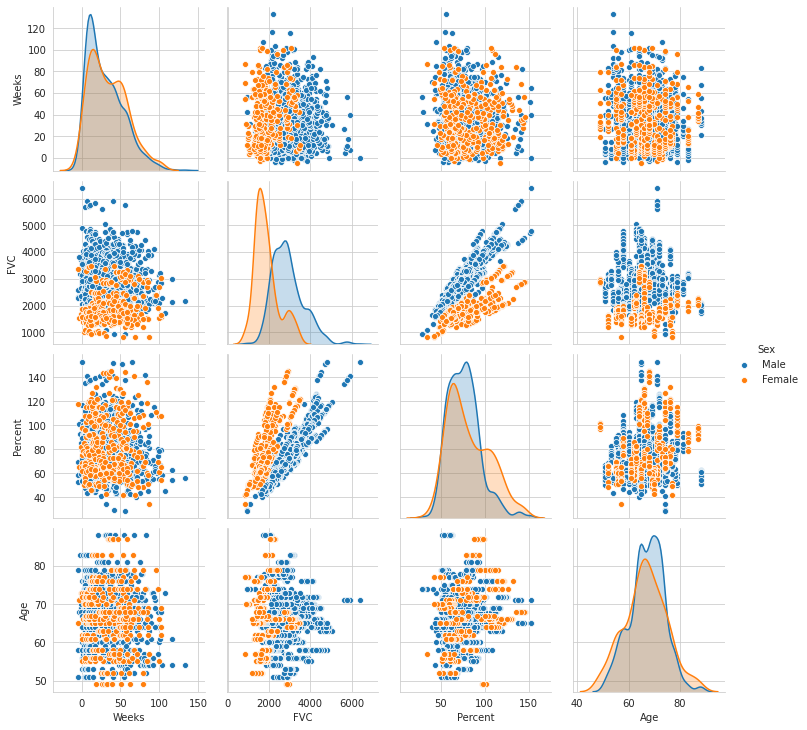

In [86]:
sns.pairplot(df_train,hue="Sex")
plt.show()

In [87]:
# rows = 5
# columns = 3
# sample_size = rows * columns
# p_id = list(df_train.Patient.sample(sample_size))
# fig, ax = plt.subplots(rows, columns, figsize = (20, 20))
#
# for row in range(rows):
#     for column in range(columns):
#         i = row * columns + column
#         sns.lineplot(x = "Weeks", y = "FVC", data = df_train[df_train.Patient == p_id[i]], ax=ax[row, column],
#                 markers = ["o", "<"])

TypeError: Cannot index by location index with a non-integer key